In [1]:
import cv2,os,math
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,precision_score,accuracy_score,roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import torchvision.models as models
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("torch.device(cuda)")
    print("torch.cuda.device_count(): ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name())
    print("torch.cuda.current_device()", torch.cuda.current_device())
else:
    device = torch.device("cpu")
    print("torch.device(cpu)")

torch.device(cuda)
torch.cuda.device_count():  4
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
Tesla V100-SXM2-16GB
torch.cuda.current_device() 0


# 1. Read data

In [147]:
# Data(x)
untreaded_train=np.load("../Classification/results2022/untreaded_train.npy",allow_pickle=True)[:1000]
# untreaded_train=np.load("../Classification/results2022/untreaded_train_all.npy",allow_pickle=True)[:10000]
VPAtreaded_train=np.load("../Classification/results2022/VPAtreaded_train.npy",allow_pickle=True)[:1000]
untreaded_test=np.load("../Classification/results2022/untreaded_test.npy",allow_pickle=True)
VPAtreaded_test=np.load("../Classification/results2022/VPAtreaded_test.npy",allow_pickle=True)

print("untreaded_train.shape:", untreaded_train.shape)
print("VPAtreaded_train.shape:", VPAtreaded_train.shape)
print("untreaded_test.shape:", untreaded_test.shape)
print("VPAtreaded_test.shape:", VPAtreaded_test.shape)

# Label(y)
y_untreaded_train = torch.zeros(len(untreaded_train), dtype=torch.int64)
y_VPAtreaded_train = torch.ones(len(VPAtreaded_train), dtype=torch.int64)
y_untreaded_test = torch.zeros(len(untreaded_test), dtype=torch.int64)
y_VPAtreaded_test = torch.ones(len(VPAtreaded_test), dtype=torch.int64)

# concatenate x and y
X_train, X_test = np.concatenate((untreaded_train, VPAtreaded_train), axis = 0), np.concatenate((untreaded_test, VPAtreaded_test), axis = 0)
y_train, y_test = torch.cat((y_untreaded_train, y_VPAtreaded_train), 0), torch.cat((y_untreaded_test, y_VPAtreaded_test), 0)

untreaded_train.shape: (1000, 100, 100, 3)
VPAtreaded_train.shape: (1000, 100, 100, 3)
untreaded_test.shape: (210, 100, 100, 3)
VPAtreaded_test.shape: (210, 100, 100, 3)


# 2. Data processing 

In [148]:
class cell_dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.transform = transforms.ToTensor()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.transform(self.x[idx]).to(torch.float), F.one_hot(self.y[idx],num_classes=2).to(torch.float)

# trainval_data = cell_dataset(X_train, y_train)
train_data = cell_dataset(X_train, y_train)
val_data = cell_dataset(X_test, y_test)

batch_size = 32
# val_size = int(len(trainval_data)*0.2)
# train_size = len(trainval_data) - val_size

# train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_valid = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [149]:
Visual_sample = []
index = [1,4,12]
for i in index:
    img = untreaded_train[i]/np.amax(untreaded_train[i])
    Visual_sample.append(img/np.amax(img))
index = [1,16,31]
for i in index:
    img = VPAtreaded_train[i]/np.amax(VPAtreaded_train[i])
    Visual_sample.append(img)
Visual_sample = np.array(Visual_sample)
y_Visual_sample = torch.tensor([0,0,0,1,1,1], dtype=torch.int64)


Visual_sample = cell_dataset(Visual_sample,y_Visual_sample)

# 3. Build Model

## 3.0 ResNet

In [150]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet,self).__init__()
        self.resnet = models.resnet18(weights=True)
        self.resnet.layer3 = nn.Sequential()
        self.resnet.layer4 = nn.Sequential()
        self.resnet.fc = nn.Linear(128, 2)
        
    def forward(self, x):
        x = self.resnet(x)
        return x

## 3.1 preBlock

In [151]:
class preBlock(nn.Module):
    def __init__(self):
        super(preBlock,self).__init__()
        self.preblock = ResNet()
        self.preblock.load_state_dict(torch.load("ResNet9C_221204.pkl"))
        self.preblock.resnet.avgpool = nn.Sequential()
        self.preblock.resnet.fc = nn.Sequential()
        
    def forward(self, x):
        x = self.preblock(x)
        x = torch.reshape(x, (x.shape[0],128,13,13))
        return x

torch.Size([1, 128, 13, 13])


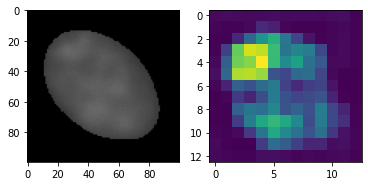

In [152]:
image_num = 1
test_input = train_data[image_num][0].unsqueeze(0).to(device)
y = preBlock().to(device)(test_input)

print(y.shape)
plt.subplot(1,2,1)
plt.imshow(train_data[image_num][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(y[0].detach().cpu().mean(dim=0))

## 3.2 lastBlock

In [153]:
class lastBlock(nn.Module):
    def __init__(self):
        super(lastBlock,self).__init__()
        self.lastblock = ResNet()
        self.lastblock.load_state_dict(torch.load("ResNet9C_221204.pkl"))
        
    def forward(self, x):
        x = self.lastblock(x)
        x = nn.Softmax(dim=1)(x)
        return x

## 3.3 UpBlock

In [154]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.double_conv(x)
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
#         self.up_sample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2)
        self.double_conv = DoubleConv(in_channels, out_channels)
    def forward(self, x, n):
#         x = self.up_sample(x)
        x = F.interpolate(x, size=[n,n], mode='nearest-exact')
        x = self.double_conv(x)
        return x

In [155]:
class UpBlock(nn.Module):
    def __init__(self):
        super(UpBlock, self).__init__()
        self.up_conv4 = Up(128, 64)
        self.up_conv3 = Up(64, 32)
        self.up_conv2 = Up(32, 16)
        self.up_conv1 = Up(16, 3)
        self.output = nn.Conv2d(3,1,kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.up_conv4(x,25)
        x = self.up_conv3(x,50)
        x = self.up_conv2(x,75)
        x = self.up_conv1(x,100)
        x = self.output(x)
        x = x/torch.amax(x)
        x = self.relu(x)
        return x

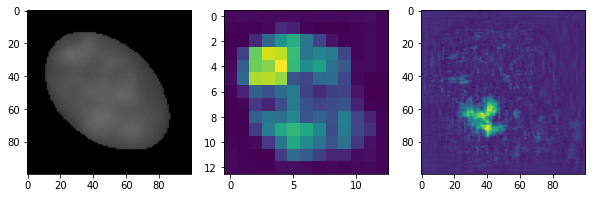

In [156]:
image_num = 1
test_input = train_data[image_num][0].unsqueeze(0).to(device)
y = preBlock().to(device)(test_input)
UpBlock().load_state_dict(torch.load("Upblock_weight_1Ccell_nearest.pkl"))
mask = UpBlock().to(device)(y)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(train_data[image_num][0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(y.detach().cpu().mean(dim=1)[0])
plt.subplot(1,3,3)
plt.imshow(mask[0].detach().cpu().permute(1,2,0))

## 3.9 MaskFM

In [169]:
class maskFM(nn.Module):
    def __init__(self):
        super(maskFM, self).__init__()
        self.preblock = preBlock()
        self.Upblock = UpBlock()
        self.Upblock.load_state_dict(torch.load("Upblock_weight_1Cone_nearest.pkl"))
        self.lastblock = lastBlock()
        
    def forward(self, input_image):
        feature = self.preblock(input_image)
        mask = self.Upblock(feature)
#         mask = mask/torch.amax(mask)
#         thre = (input_image>0).float()[:,0,:,:].unsqueeze(1)
#         mask = torch.multiply(mask, thre)

        # ResNet
        masked_image = torch.multiply(mask, input_image)
        output = self.lastblock(masked_image)
        return feature, mask, output

In [170]:
model = maskFM().to(device)

## 3.3 Param setting

In [171]:
# >> Freeze UNet weights
for param in model.preblock.parameters():
    param.requires_grad = False
for param in model.lastblock.parameters():
    param.requires_grad = False

In [172]:
ngpu = 4
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))

In [173]:
# model.load_state_dict(torch.load("./maskUNet_model/cell1C-Sigmoid-PixelLoss.pkl"))

## 3.4 Loss

In [174]:
class mask_Loss(nn.Module):
    def __init__(self):
        super(mask_Loss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')

    def forward(self, mask, input_image): 
        bin_image = (input_image==0).float()
        allzero = torch.zeros(bin_image.shape).to(device)
        mask = torch.multiply(mask, bin_image)
        return self.mse_loss(allzero, mask).sum()

In [175]:
class pixel_Loss(nn.Module):
    def __init__(self):
        super(pixel_Loss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction='none')

    def forward(self, mask, input_image): 
        bin_image = (input_image>0).float()
        mask = torch.multiply(mask, bin_image)
        
        allzero = torch.zeros(bin_image.shape).to(device)
        overzero = torch.min(mask, allzero)
        return -overzero.sum()

In [176]:
model.avgpool = nn.AdaptiveAvgPool2d(1)
criterion_mask = mask_Loss()
criterion_label = nn.BCELoss()
criterion_pixel = pixel_Loss()
# criterion_label = nn.CrossEntropyLoss()

# 0.0 demo test

 mask loss:  tensor(13808.5703, device='cuda:0', grad_fn=<SumBackward0>)
label loss:  tensor(8.3899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
predict y:  tensor([[2.2715e-04, 9.9977e-01]], device='cuda:0', grad_fn=<GatherBackward>)


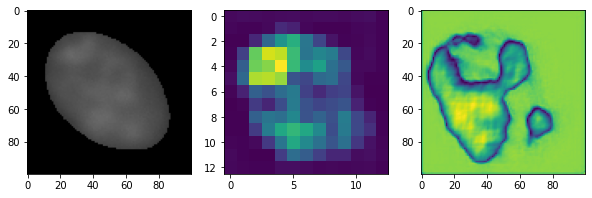

In [177]:
image_num = 1
test_input = train_data[image_num][0].unsqueeze(0).to(device)
feature, mask, y = model(test_input)
print(" mask loss: ", criterion_mask(mask, test_input))
# print("pixel loss: ", criterion_pixel(mask, test_input))
print("label loss: ", criterion_label(y, train_data[image_num][1].unsqueeze(0).to(device)))

print("predict y: ",y)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(train_data[image_num][0].permute(1,2,0))
plt.subplot(1,3,2)
plt.imshow(feature.detach().cpu().mean(dim=1)[0])
plt.subplot(1,3,3)
plt.imshow(mask[0].detach().cpu().permute(1,2,0))

# 4. Train

In [178]:
def title(label):
    if label==0:
        return "untreated"
    else:
        return "VPA-treated"

In [179]:
losstrain=[]
lossvalid=[]
Accuracytrain=[]
Accuracyvalid=[]

optimizer = torch.optim.Adam(model.parameters(), lr=3e-7)  # 定义优化器
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99) # 定义衰减策略

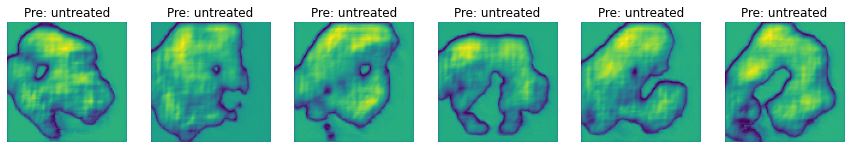

EPOCH0, Train[Loss_mask:368125.398, Loss_label:2.728, Accuracy:0.708], Valid[Loss:3.179, Accuracy:0.693]
EPOCH1, Train[Loss_mask:348427.560, Loss_label:2.750, Accuracy:0.688], Valid[Loss:3.373, Accuracy:0.686]
EPOCH2, Train[Loss_mask:333309.900, Loss_label:2.724, Accuracy:0.703], Valid[Loss:3.018, Accuracy:0.710]
EPOCH3, Train[Loss_mask:315190.432, Loss_label:2.879, Accuracy:0.708], Valid[Loss:3.063, Accuracy:0.707]
EPOCH4, Train[Loss_mask:299614.250, Loss_label:2.728, Accuracy:0.693], Valid[Loss:3.632, Accuracy:0.683]


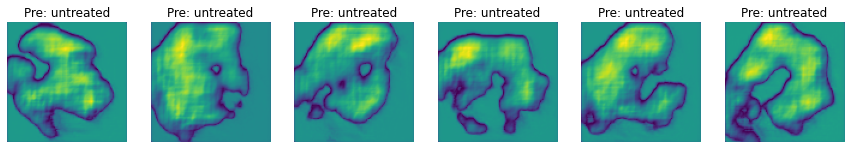

EPOCH5, Train[Loss_mask:284500.573, Loss_label:2.635, Accuracy:0.697], Valid[Loss:2.946, Accuracy:0.700]
EPOCH6, Train[Loss_mask:268901.272, Loss_label:2.716, Accuracy:0.683], Valid[Loss:3.790, Accuracy:0.660]


KeyboardInterrupt: 

In [180]:
n_epochs = 50
for epoch in range(n_epochs):
    losses_train = []
    losses_mask = []
    losses_pixel = []
    losses_label = []
    losses_valid = []
    
    # Train
    optimizer.step()
    model.train()
    n_train = 0
    acc_train = 0
    for x, y in dataloader_train:
        n_train += y.size()[0]
        model.zero_grad()
        x = x.to(device)
        y = y.to(device)
        feature, mask, output = model.forward(x)
        
        loss_mask = criterion_mask(mask, x)
        loss_pixel = criterion_pixel(mask, x)
        loss_label = criterion_label(output, y)
        loss = loss_label + loss_mask
        loss.backward()
        optimizer.step()
        acc_train += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_train.append(loss.tolist())
        losses_mask.append(loss_mask.tolist())
        losses_pixel.append(loss_pixel.tolist())
        losses_label.append(loss_label.tolist())


    # Evaluate
    model.eval()
    if epoch%5==0:
        plt.figure(figsize=(15,15))
        for i in range(6):
            img = Visual_sample[i][0].permute(1,2,0).numpy()
            label = Visual_sample[i][1][1]
            input_tensor = Visual_sample[i][0].unsqueeze(0).to(device)
            feature, mask, output = model(input_tensor)
            y = output.argmax(1).cpu().item()
            mask = mask[0].detach().cpu().permute(1,2,0)
            plt.subplot(1,6,i+1)
            plt.axis('off')
            plt.title("Pre: "+title(y))
            plt.imshow(mask)
        plt.show()
        
    n_val = 0
    acc_val = 0
    for x, y in dataloader_valid:
        n_val += y.size()[0]
        x = x.to(device)
        y = y.to(device)
        feature,mask,output = model.forward(x)
        loss = criterion_label(output, y)
        pred = output.argmax(1)
        acc_val += (output.argmax(1) == y[:,1]).float().sum().item()
        losses_valid.append(loss.tolist())
    scheduler.step()
    # Visualize loss & accuracy    
    losstrain.append(np.mean(losses_train))
    Accuracytrain.append(acc_train/n_train)
    lossvalid.append(np.mean(losses_valid))
    Accuracyvalid.append(acc_val/n_val)
    print('EPOCH{}, Train[Loss_mask:{:.3f}, Loss_label:{:.3f}, Accuracy:{:.3f}], Valid[Loss:{:.3f}, Accuracy:{:.3f}]'
          .format(epoch,np.mean(losses_mask),np.mean(losses_label),acc_train/n_train,np.mean(losses_valid),acc_val/n_val))

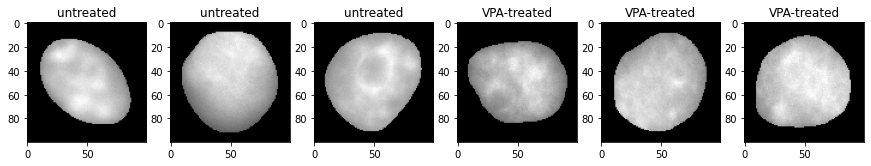

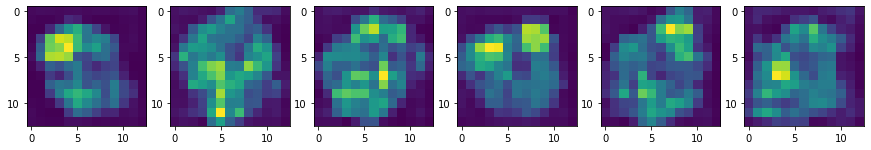

In [26]:
plt.figure(figsize=(15,15))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.title(title(Visual_sample[i][1][1]))
    plt.imshow(Visual_sample[i][0].permute(1,2,0).numpy())
plt.show()

plt.figure(figsize=(15,15))
for i in range(6):
    img = preBlock().to(device)(Visual_sample[i][0].unsqueeze(0).to(device))[0].detach().cpu().mean(dim=0)
    plt.subplot(1,6,i+1)
    plt.imshow(img)
plt.show()

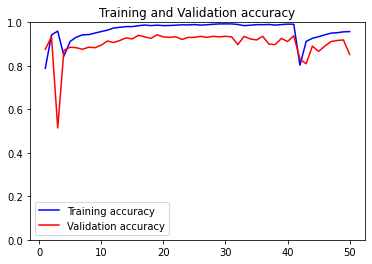

<Figure size 432x288 with 0 Axes>

In [128]:
# train processing plot
n_epochs = 50
epochs=range(1,n_epochs+1)
plt.ylim(0,1.0)
plt.plot(epochs,Accuracytrain,'b',label='Training accuracy')  
plt.plot(epochs, Accuracyvalid,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.show()

In [422]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.state_dict(),"./maskUNet_model/cell1C-Sigmoid-None.pkl")

total_test: 420
accuracy_score: 0.788
precision_score: 0.842
roc_auc_score: 0.887


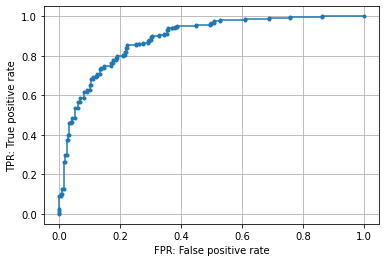

In [423]:
# Test
X = X_test
y = y_test
y_pred = []
out_pred = []
total = X.shape[0]

model.eval()
for n in range(total):
    img = X[n]
    label = y[n]
    transform = transforms.Compose([transforms.ToTensor()])
    input_tensor = transform(img).unsqueeze(0).to(device)
    mask,output = model(input_tensor)
    pred = output.argmax(1).cpu().item()
    out_pred.append(output[0][1].item())
    y_pred.append(pred)

y_pred = np.array(y_pred)
out_pred = np.array(out_pred)
print("total_test: {:}" .format(total))
print('accuracy_score: {:.3f}'.format(accuracy_score(y,y_pred)))
print('precision_score: {:.3f}'.format(precision_score(y,y_pred)))
print('roc_auc_score: {:.3f}'.format(roc_auc_score(y, out_pred)))

fpr, tpr, thresholds = roc_curve(y, out_pred,drop_intermediate=True)
plt.plot(fpr, tpr, marker='.')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 4. Mask

In [445]:
model.load_state_dict(torch.load("./maskUNet_model/cell1C-ReLU-multiply.pkl"))

<All keys matched successfully>

In [66]:
i = 1
img = train_data[i][0].permute(1,2,0).numpy()
label = train_data[i][1][1]
input_tensor = train_data[i][0].unsqueeze(0).to(device)
feature, mask, output = model(input_tensor)
y = output.argmax(1).cpu().item()
print("y is",y , "; pre is", label.item(), "=>",y==label.item())

y is 1 ; pre is 0.0 => False


max: 0.108, min: 0.000


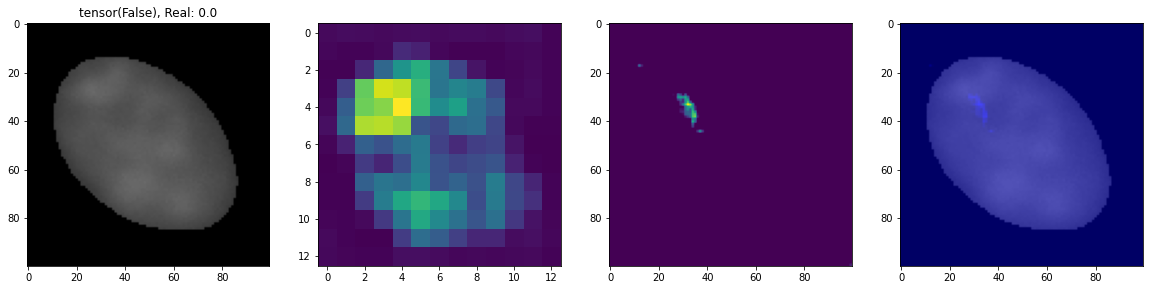

In [67]:
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.title(str(y==label)+", Real: "+str(label.item()))
plt.imshow(img)
plt.subplot(1,4,2)
plt.imshow(feature[0].detach().cpu().mean(dim=0))
mask = mask[0].detach().cpu().permute(1,2,0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(mask),torch.amin(mask)))
plt.subplot(1,4,3)
plt.imshow(mask)

plt.subplot(1,4,4)
cam = show_cam_on_image(img, mask, True)
plt.imshow(cam)

# 5. Feature map

In [65]:
# 定义钩子函数，获取指定层名称的特征
feature_activation = {} # 保存获取的输出
def get_activation(name):
    def hook(model, input, output):
        feature_activation[name] = output.detach()
    return hook

for name, layer in model.named_modules():
    layer.register_forward_hook(get_activation(name))
    print(name)


pre_layer
pre_layer.0
pre_layer.1
pre_layer.2
residual_layer
residual_layer.0
residual_layer.0.residualblock
residual_layer.0.residualblock.0
residual_layer.0.residualblock.1
residual_layer.0.residualblock.2
residual_layer.0.residualblock.3
residual_layer.0.residualblock.4
residual_layer.0.residualblock.5
residual_layer.0.residualblock.6
residual_layer.0.residualblock.7
residual_layer.1
residual_layer.1.residualblock
residual_layer.1.residualblock.0
residual_layer.1.residualblock.1
residual_layer.1.residualblock.2
residual_layer.1.residualblock.3
residual_layer.1.residualblock.4
residual_layer.1.residualblock.5
residual_layer.1.residualblock.6
residual_layer.1.residualblock.7
residual_layer.2
residual_layer.2.residualblock
residual_layer.2.residualblock.0
residual_layer.2.residualblock.1
residual_layer.2.residualblock.2
residual_layer.2.residualblock.3
residual_layer.2.residualblock.4
residual_layer.2.residualblock.5
residual_layer.2.residualblock.6
residual_layer.2.residualblock.7
ma

In [79]:
# for name, layer in model.named_modules():
#     bn = feature_activation[name].cpu()[0]
#     print('max: {:.3f}, min: {:.3f}'.format(torch.amax(bn),torch.amin(bn)))
#     if bn.shape[0]==10000:
#         bn = bn.reshape(100,100)
#         plt.title(name)
#         plt.imshow(bn)
#         plt.show()

max: 15.391, min: 0.000


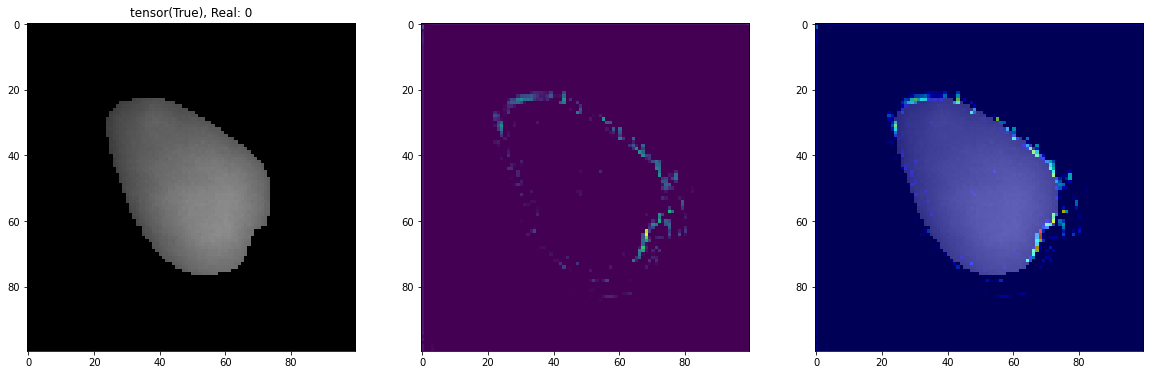

In [80]:
key = "mask_layer"
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title(str(y==label)+", Real: "+str(label.item()))
plt.imshow(img)

mask = feature_activation[key].cpu()[0].mean(axis=0)
print('max: {:.3f}, min: {:.3f}'.format(torch.amax(mask),torch.amin(mask)))
mask = cv2.normalize(mask.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
cam = show_cam_on_image(img, mask, True)
plt.imshow(cam)

In [146]:
# num = feature_activation[key].cpu()[0].shape[0]
# num = 10
# for i in range(num):
#     plt.figure(figsize=(10,10))
#     plt.subplot(1,3,1)
#     plt.title(y==label)
#     plt.imshow(img/np.amax(img))
    
#     bn = feature_activation[key].cpu()[0][i]
#     bn = cv2.normalize(bn.numpy(), None, alpha=0,beta=1, norm_type=cv2.NORM_MINMAX)
#     plt.subplot(1,3,2)
#     plt.title(key)
#     plt.imshow(bn)
    
#     plt.subplot(1,3,3)
#     plt.axis("off")
#     bn = cv2.merge([bn,bn,bn])
#     cam = show_cam_on_image(img, bn)
#     plt.imshow(cam)

In [62]:
for key in feature_activation:
    bn = feature_activation[key].cpu()
    print(key," : ",bn.shape)

pre_layer.0  :  torch.Size([1, 64, 100, 100])
pre_layer.1  :  torch.Size([1, 64, 100, 100])
pre_layer.2  :  torch.Size([1, 64, 100, 100])
pre_layer  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.2  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.3  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.4  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.5  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.6  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock.7  :  torch.Size([1, 64, 100, 100])
residual_layer.0.residualblock  :  torch.Size([1, 64, 100, 100])
residual_layer.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.0  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.1  :  torch.Size([1, 64, 100, 100])
residual_layer.1.residualblock.2

# 5. GradCAM

In [128]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,deprocess_image,preprocess_image

def gradcams(model,input_tensor,target_layers,imgpad,optioncam):
    # GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
    if optioncam=="GradCAM":
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="ScoreCAM":
        cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="GradCAMPlusPlus":
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="AblationCAM":
        cam = AblationCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="XGradCAM":
        cam = XGradCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="EigenCAM":
        cam = EigenCAM(model=model, target_layers=target_layers, use_cuda=True)
    elif optioncam=="FullGrad":
        cam = FullGrad(model=model, target_layers=target_layers, use_cuda=True)
    else:
        return print("your option is not support")
    # Note: input_tensor can be a batch tensor with several images!
    # If None, returns the map for the highest scoring category. 
    # Otherwise, targets the requested index. target_index = 1
    targets = None
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor,targets=targets,aug_smooth=True,eigen_smooth=True)
    grayscale_cam = cam(input_tensor, targets)[0]
    # In this example grayscale_cam has only one image in the batch:
    visualization = show_cam_on_image(imgpad, grayscale_cam, use_rgb=True)
    
    # Guided-GradCAM
    gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)
    gb = gb_model(input_tensor, targets)
#     if np.amax(gb)!=0:
#         gb = np.maximum(gb,0)*(1/np.amax(gb))
    cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    cam_gb = cam_mask * gb
    
    return visualization,gb,cam_gb,cam_mask

tensor(True)


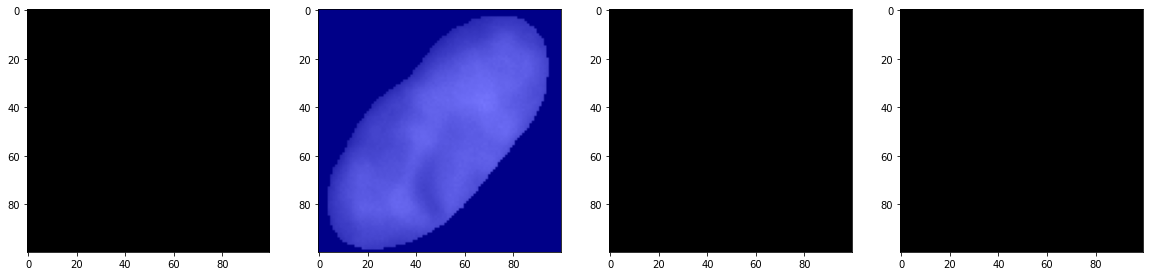

In [203]:
target_layers = [model.last_layer[0]]
# cam's option: GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, ScoreCAM, FullGrad
optioncam = "GradCAM"
visualization,gb,cam_gb,cam = gradcams(model,input_tensor,target_layers,img,optioncam)
print(y==label)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(cam)
plt.subplot(1,4,2)
plt.imshow(visualization)
plt.subplot(1,4,3)
plt.imshow(gb)
plt.subplot(1,4,4)
plt.imshow(cam_gb)

# 99. save model

In [59]:
for param in model.parameters():
    param.requires_grad = True
torch.save(model.state_dict(),"maskUNet.pkl")